# 環境の設定

In [1]:
from blindcliftwalk import BlindCliftwalk

# ゴールまでの距離
nb_step = 20
#nb_step = 10

# ゴールの数
nb_goals = 3
#nb_goals = 1

env = BlindCliftwalk(nb_step, nb_goals)

In [2]:
import numpy as np

np.random.seed(seed=50)
env.set_ground_truth()
env.ground_truth

array([[2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

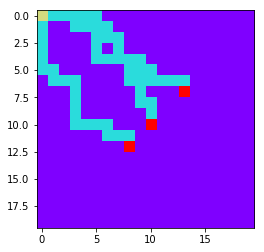

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
#plt.savefig('ground_truth.png')

# value functionをTD学習で学習する
- [prioritized experience replay](https://arxiv.org/abs/1511.05952)を使用。

In [4]:
#  state value更新回数
mc_step = 300000
#mc_step = 3000

# 割引率
gamma = 1. - 1. / float(nb_step)

# 学習率
learning_rate = 0.25

# 考えうる状態の数はground_truthの大きさと同じ（もう少し小さいが、面倒なので同じとする）
value_table = np.zeros_like(env.ground_truth, dtype=float)

# ゴール到達後のstate valueの保存間隔
#save_interval = 10000
save_interval = 1000

# Prioritized Experience Replayのハイパーパラメータ。α=0でランダムサンプリング
alpha = 1.
#alpha = 0.
beta = 1.

# ε-greedyのハイパーパラメータ
epsilon = 0.3

In [5]:
def gumbel_sampling(prob):
    rand = np.random.random(len(prob))
    g = -np.log(-np.log(rand))
    return np.argmax(g+np.log(prob))
#    return np.argmax(prob)

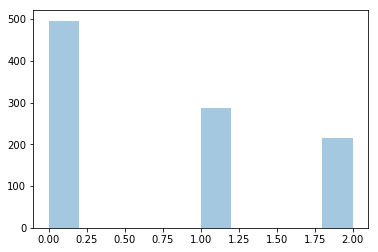

In [6]:
prob = [0.5, 0.3, 0.2]
hist=[]
for _ in range(1000):
    hist.append(gumbel_sampling(prob))

import seaborn as sns
sns.distplot(hist, kde=False)

In [7]:
def trans_prob(priorities, alpha):
    foo = np.array(priorities)**alpha
    return foo / np.array(foo).sum()

In [8]:
from tqdm import tqdm

stacked_value_table = []
isSuccessed = False

value_table = np.zeros_like(value_table) # state valueの初期化（念のためループ直前でも初期化する）
experience = []
priorities = []
#eps = np.finfo(float).eps
eps = 1e-5
try:
    count = 0
    for i in tqdm(range(mc_step)):
        # 状態の初期化
        current_state  = np.zeros(2, dtype=int)

        status = 0
        while status >= 0:
            # state valueが最大となる行動を取る（まだ遷移させない）。
            if np.random.random(1) > epsilon:
                action_candidates = [[0,1], [1,0]]
                next_state_1, _, _ = env.do_action(current_state, action_candidates[0])
                next_state_2, _, _ = env.do_action(current_state, action_candidates[1])
                v1 = value_table[next_state_1[0], next_state_1[1]]
                v2 = value_table[next_state_2[0], next_state_2[1]]
                v_candidates = np.array([v1,v2])
                action = action_candidates[v_candidates.argmax()]
            else:
                action = env.random_action()
                
            # 行動に対する報酬と遷移後の状態の計算
            next_state, reward, status = env.do_action(current_state, action)
            
            if status==1:
                isSuccessed = True

            if status>=0:                
                # とりあえず最大priorityで遷移を経験に保存する。一度でもこの経験が再生されればpriorityは更新される。
                try:
                    priority = np.array(priorities).max()
                except:
                    priority = 1.
                experience.append((current_state, action, next_state, reward))
                priorities.append(priority)
                
                # 経験が100個以上溜まったら、priorityの低い経験から削除していく。
                if len(priorities)>100:
                    del_idx = np.array(priorities).argmin()
                    experience.pop(del_idx)
                    priorities.pop(del_idx)
                
                # experience replay: 経験の中からpriorityの高い遷移をサンプリングして、state valueの更新に使う。
                prob = trans_prob(priorities, alpha)
                replay_idx = gumbel_sampling(prob)
                s1, _, s2, r = experience[replay_idx]
                V_1 = value_table[s1[0], s1[1]]
                V_2 = value_table[s2[0], s2[1]]
                replayed_td_error = r + gamma * V_2 - V_1
#                weight = (1./prob[replay_idx]/float(len(priorities)))**beta
                weight = 1.
                value_table[s1[0], s1[1]] = V_1 + learning_rate * weight * replayed_td_error

                #一度再生された経験のpriorityを更新する
                priorities[replay_idx] = abs(replayed_td_error) + eps
        
                # 状態の遷移（マス目の移動）
                current_state = next_state
                
                if isSuccessed:
#                if True:
                    count += 1
                    if count==save_interval:
                        stacked_value_table.append(np.copy(value_table))
                        count = 0
            
except Exception:
    pass

100%|██████████| 300000/300000 [02:23<00:00, 2087.40it/s]


# 学習過程の可視化
- TD学習では一度ゴールまでたどり着くとその後常にstate valueが更新される。

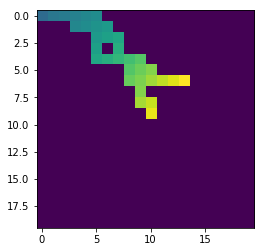

In [9]:
plt.imshow(value_table, interpolation='nearest')
plt.clim(0,1)

In [10]:
len(stacked_value_table)

1577

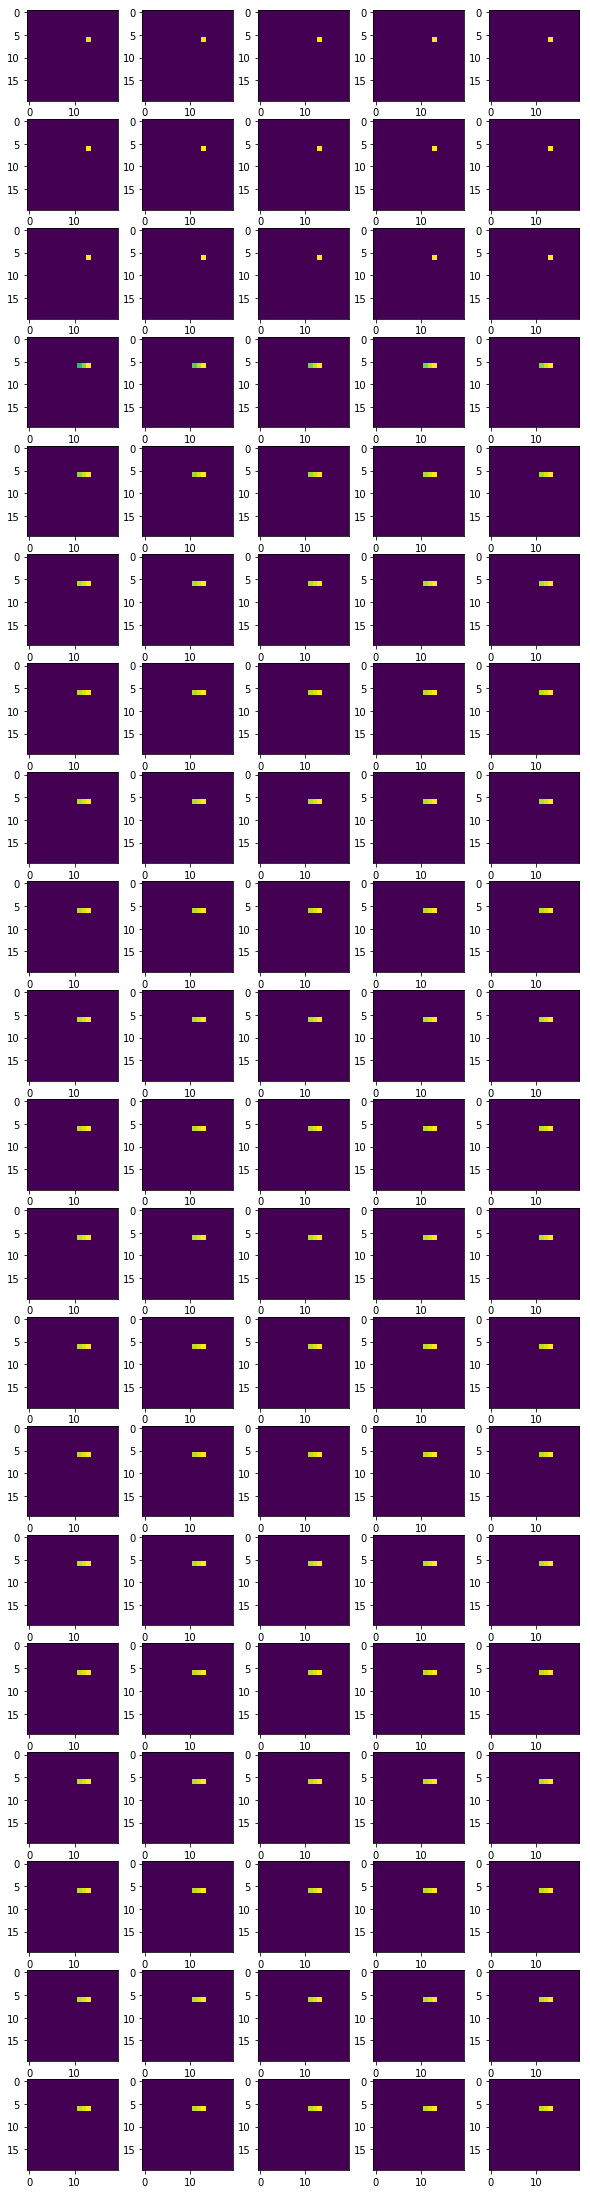

In [11]:
if isSuccessed:
    nb_show = 100
    nb = 0
    plt.figure(figsize=(10,10*int(len(stacked_value_table[:nb_show])+1)/5.))
    for v in stacked_value_table[:nb_show]:
        nb += 1
        plt.subplot(int(len(stacked_value_table[:nb_show])+1),5,nb)
        plt.imshow(v, interpolation='nearest')
        plt.clim(0,1)

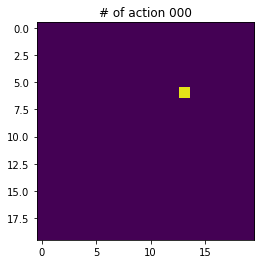

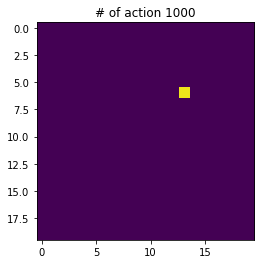

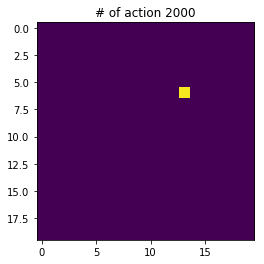

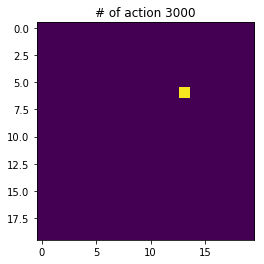

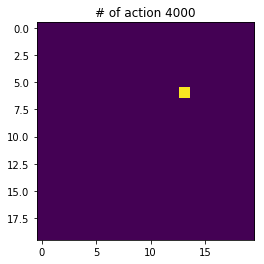

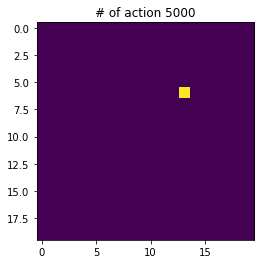

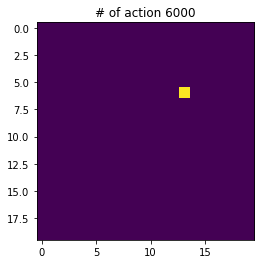

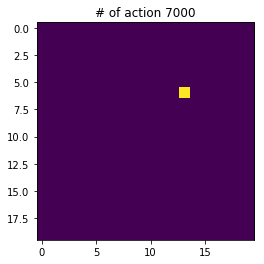

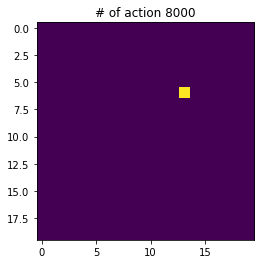

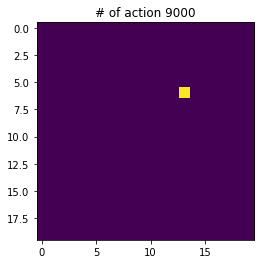

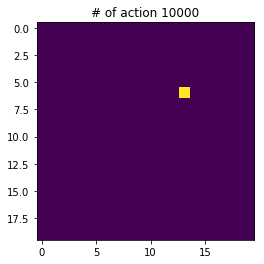

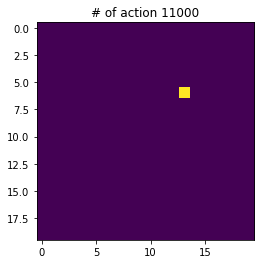

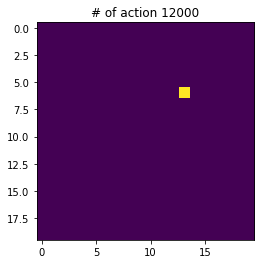

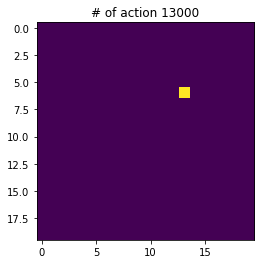

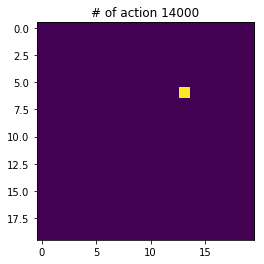

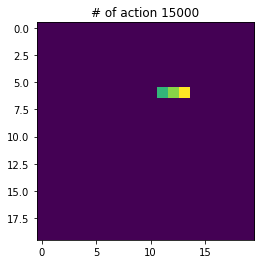

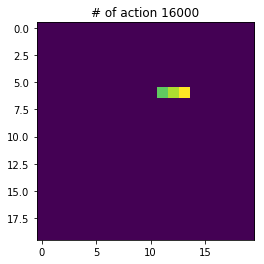

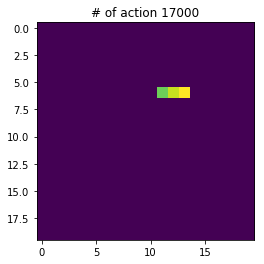

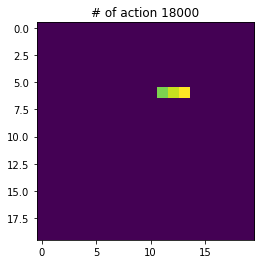

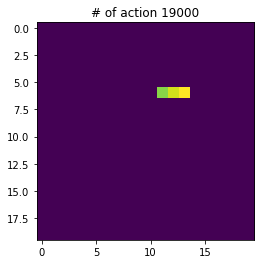

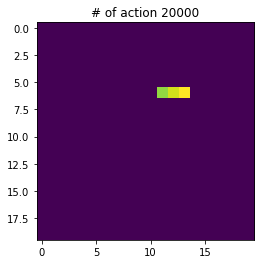

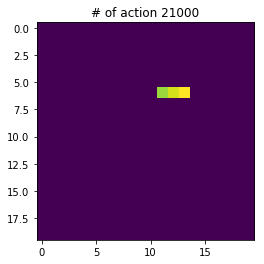

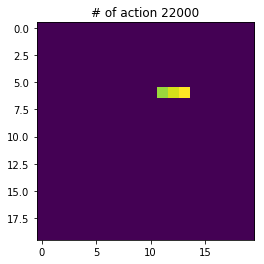

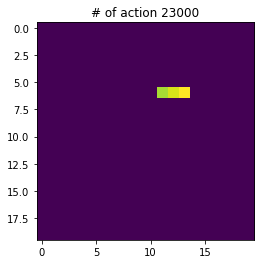

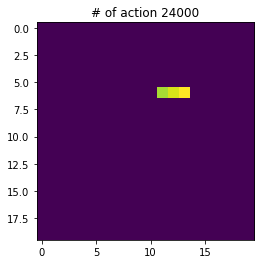

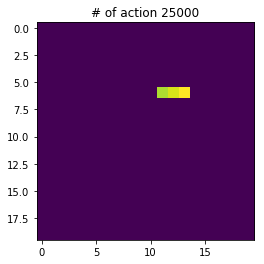

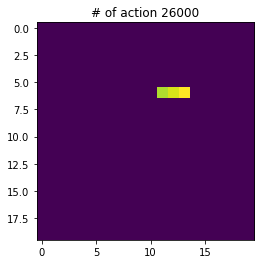

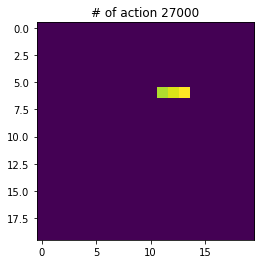

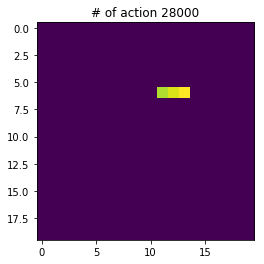

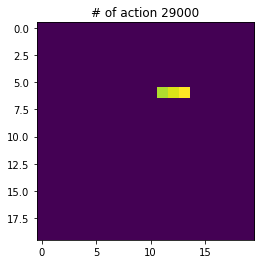

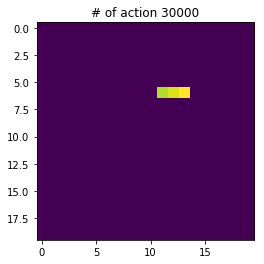

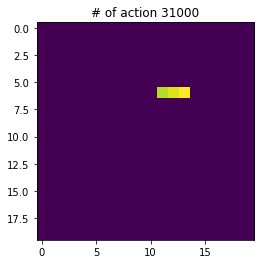

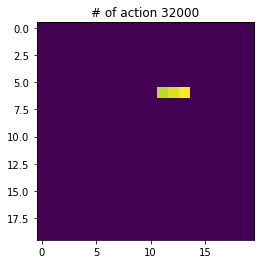

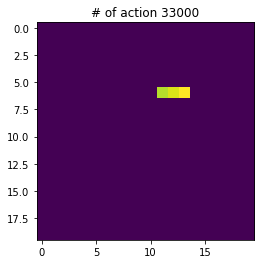

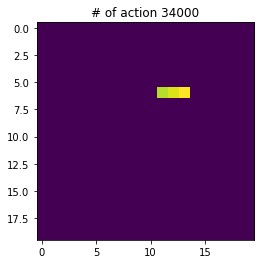

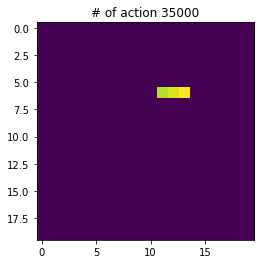

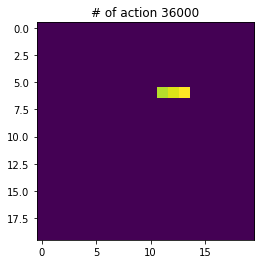

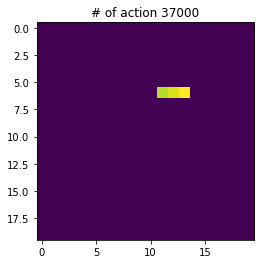

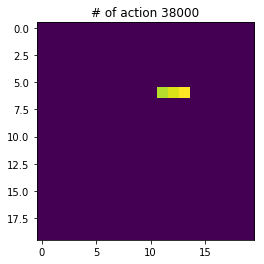

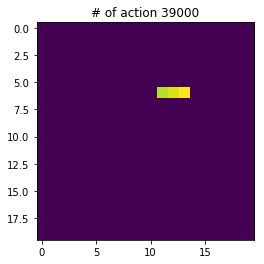

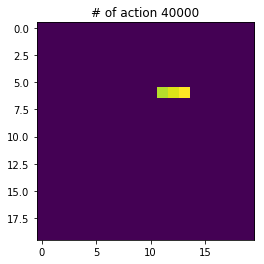

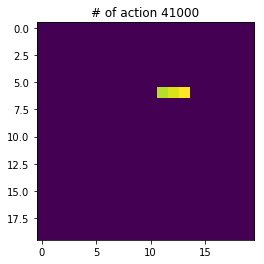

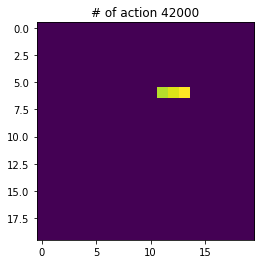

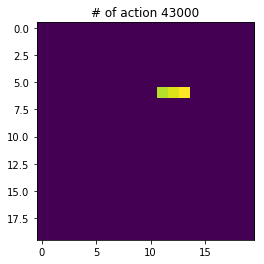

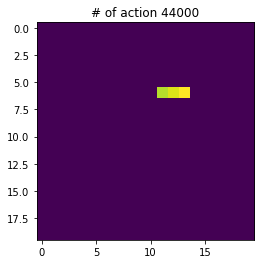

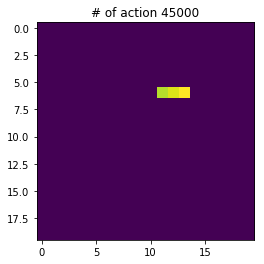

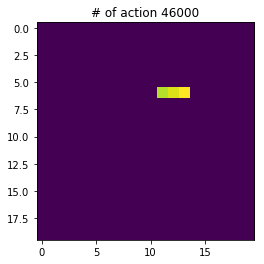

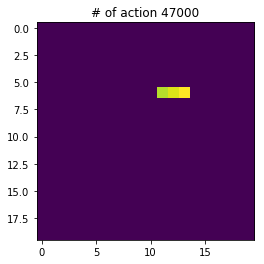

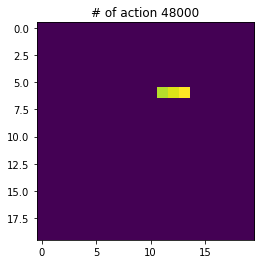

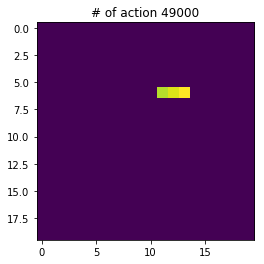

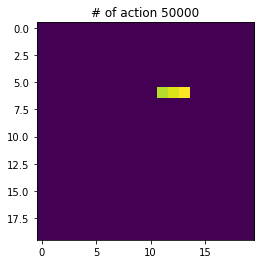

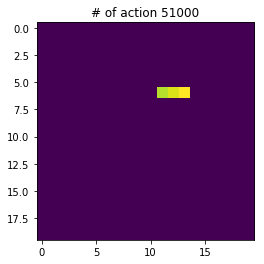

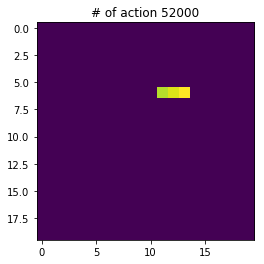

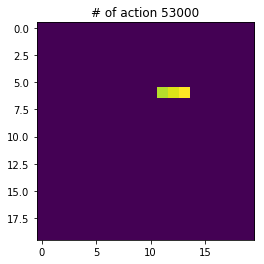

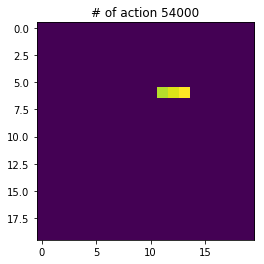

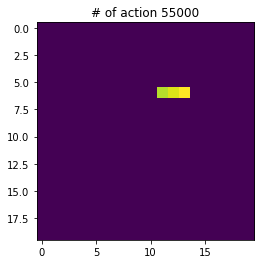

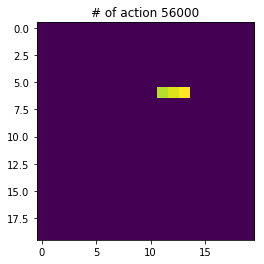

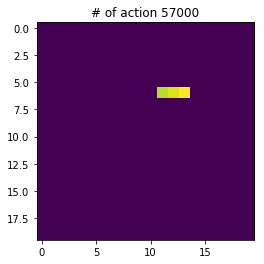

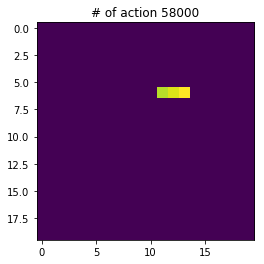

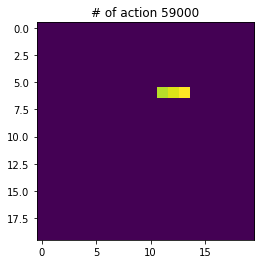

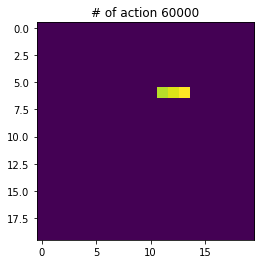

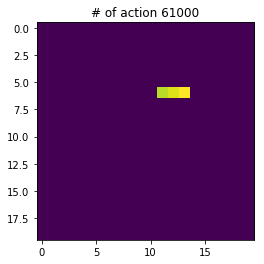

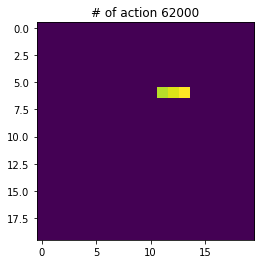

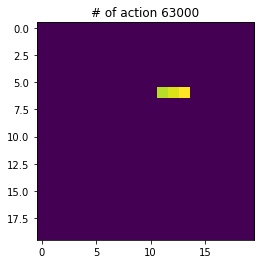

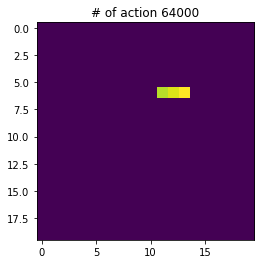

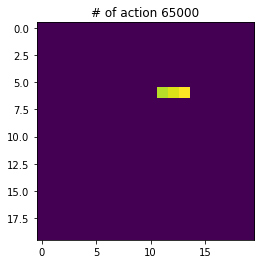

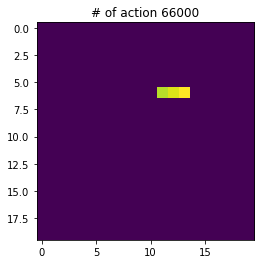

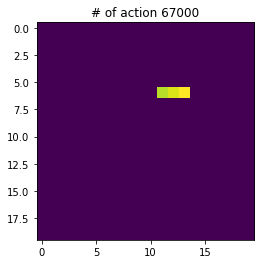

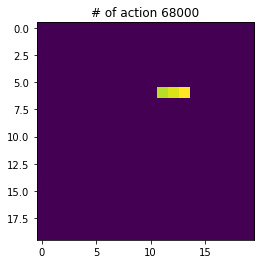

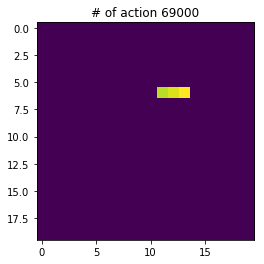

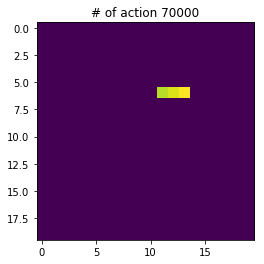

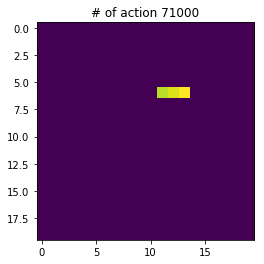

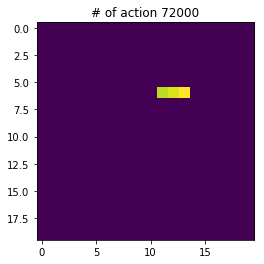

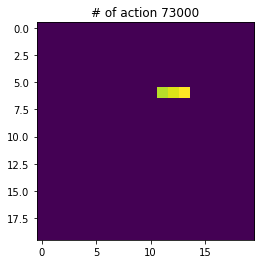

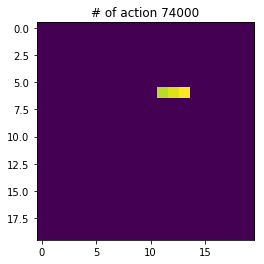

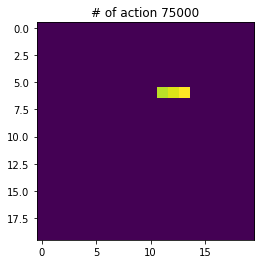

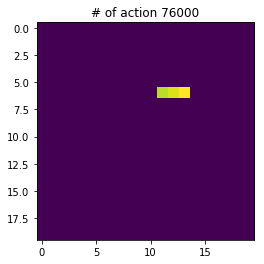

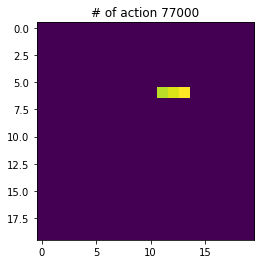

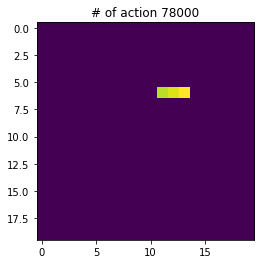

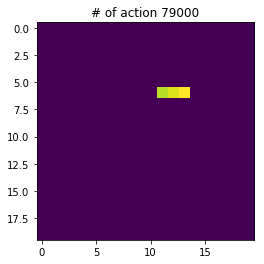

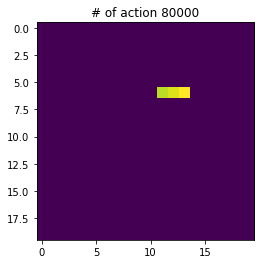

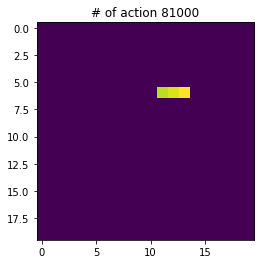

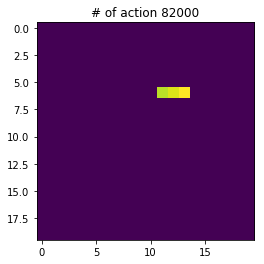

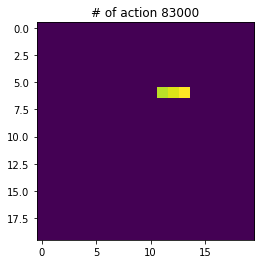

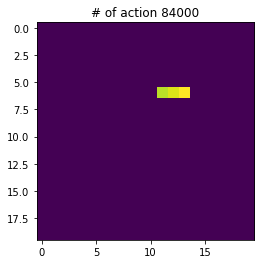

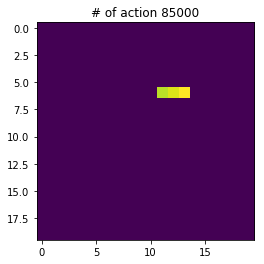

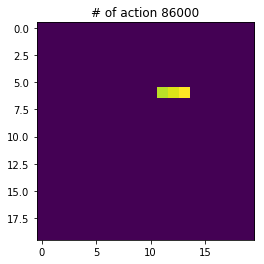

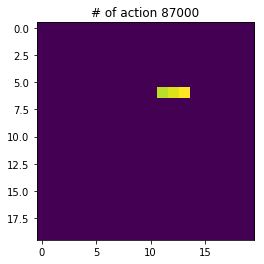

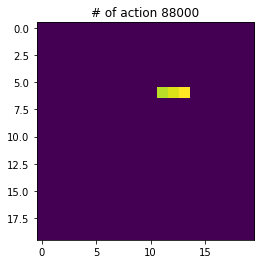

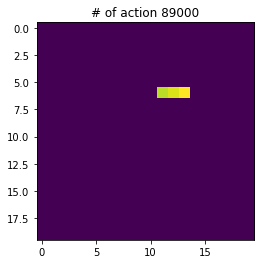

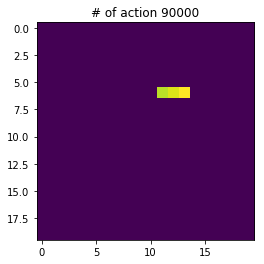

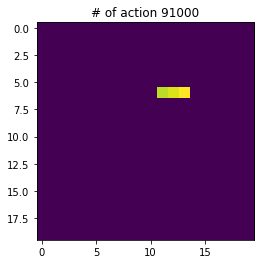

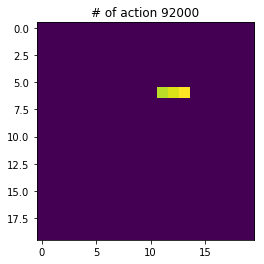

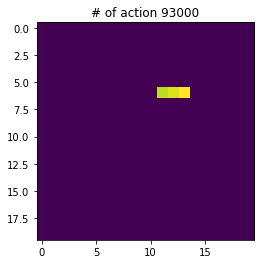

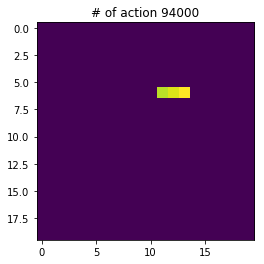

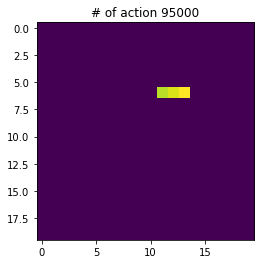

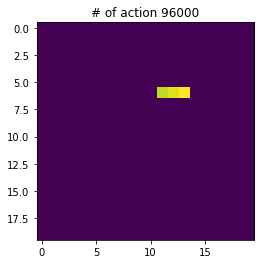

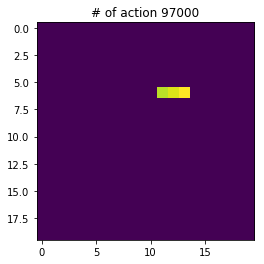

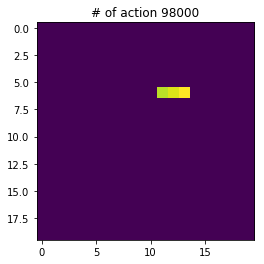

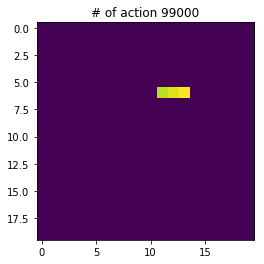

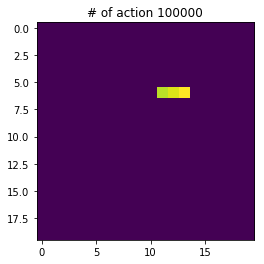

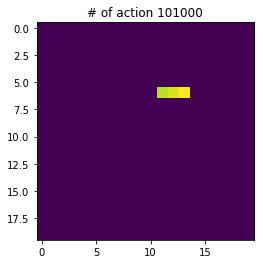

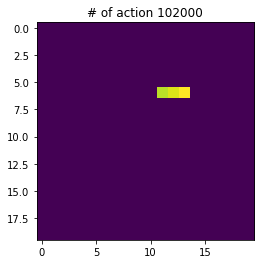

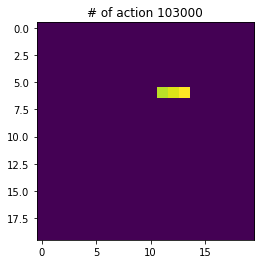

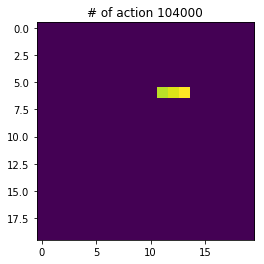

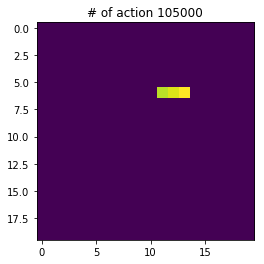

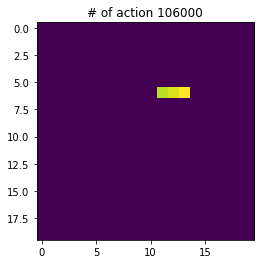

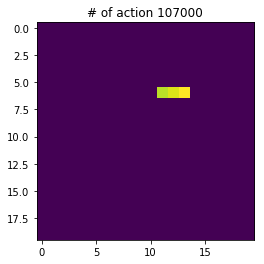

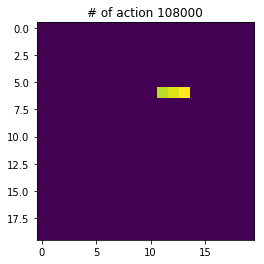

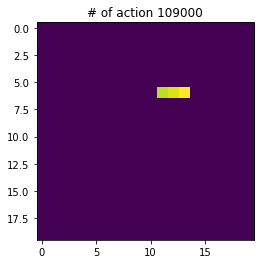

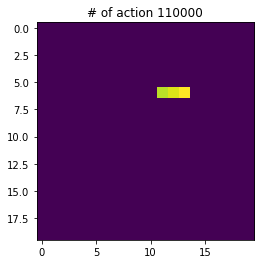

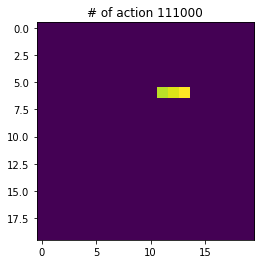

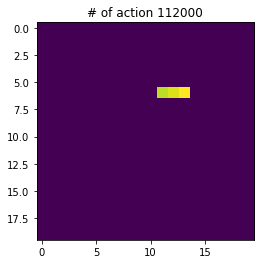

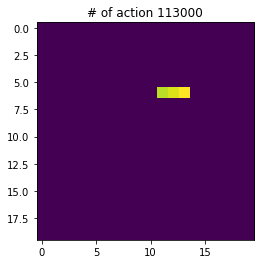

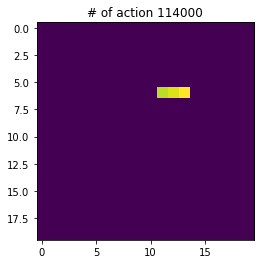

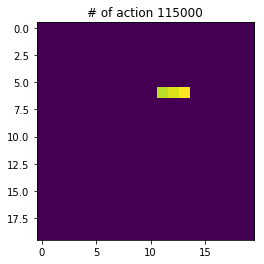

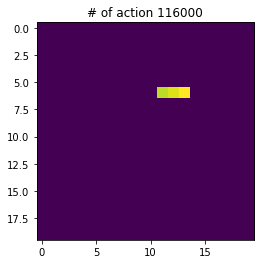

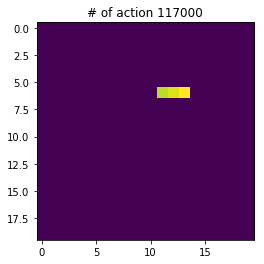

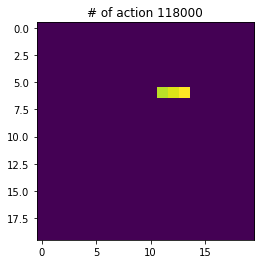

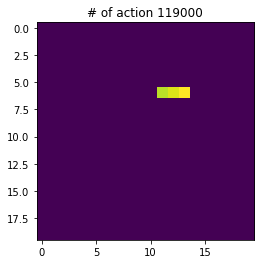

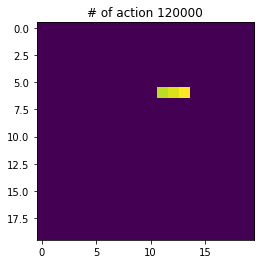

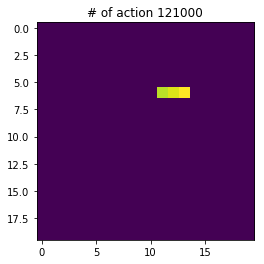

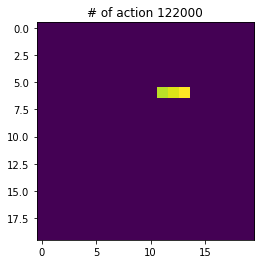

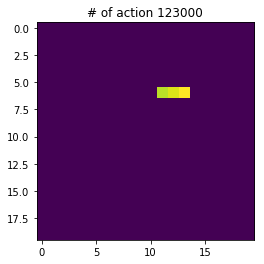

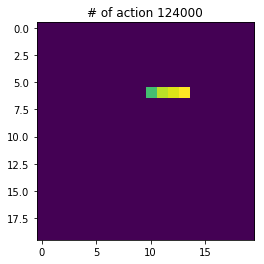

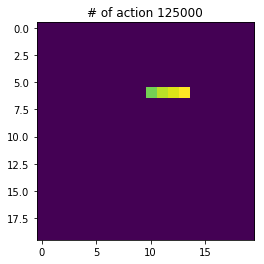

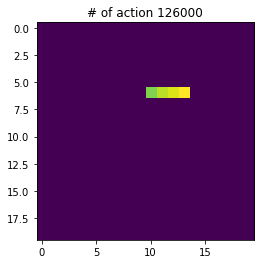

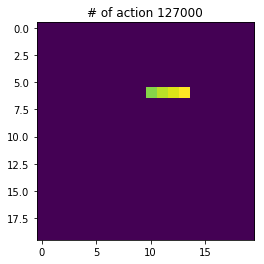

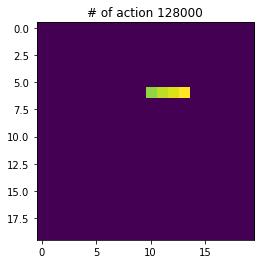

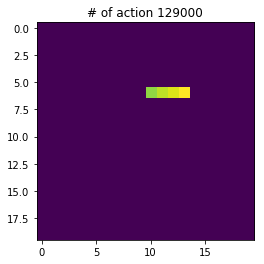

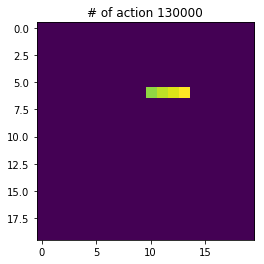

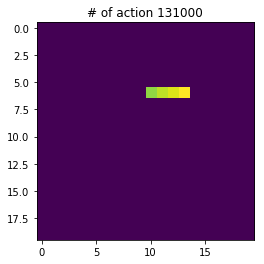

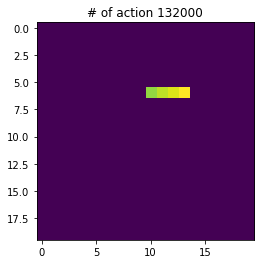

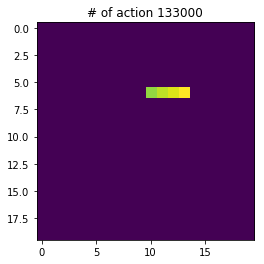

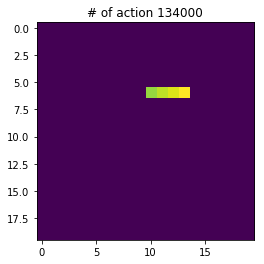

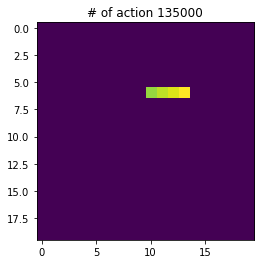

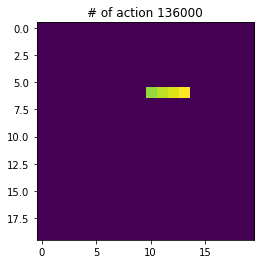

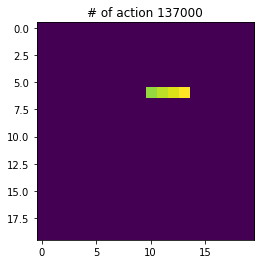

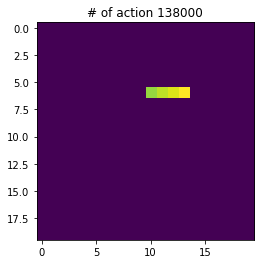

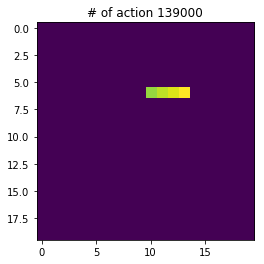

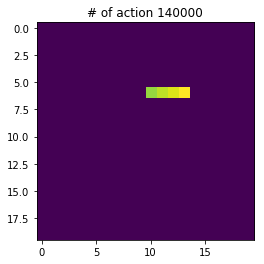

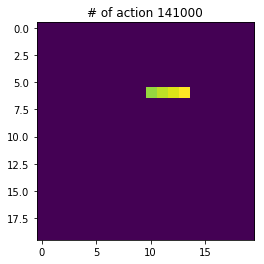

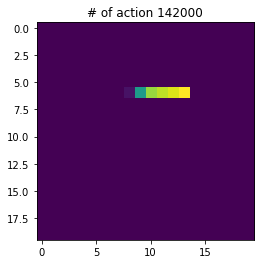

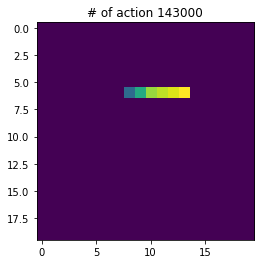

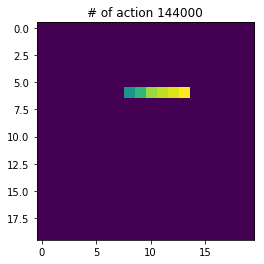

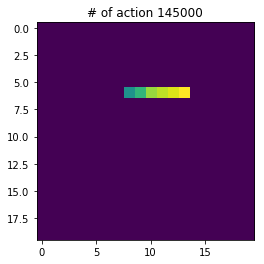

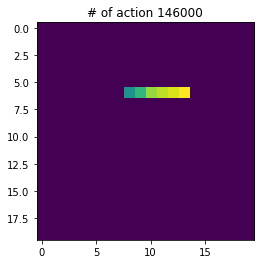

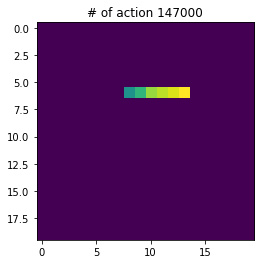

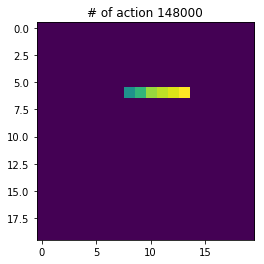

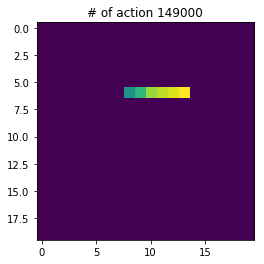

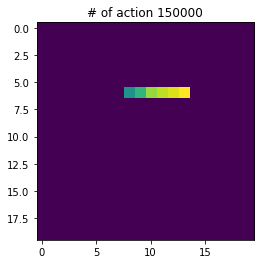

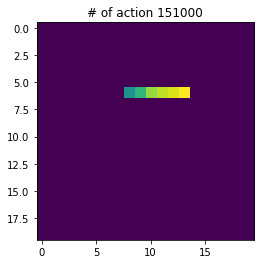

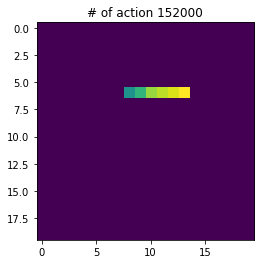

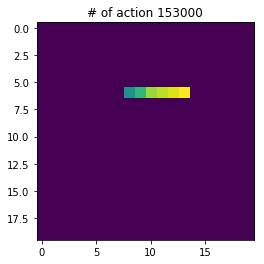

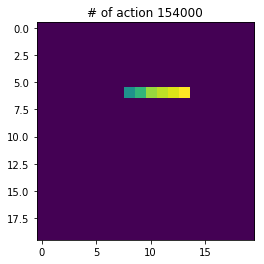

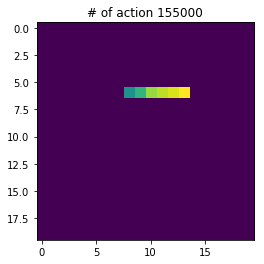

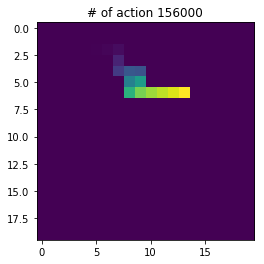

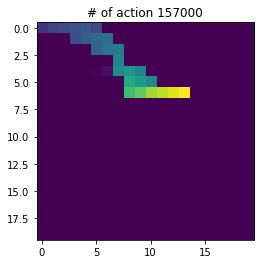

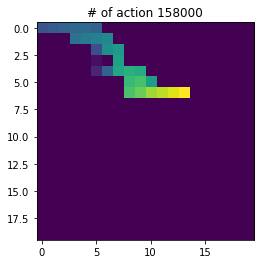

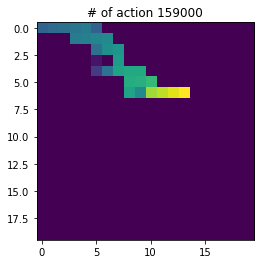

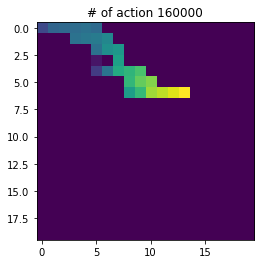

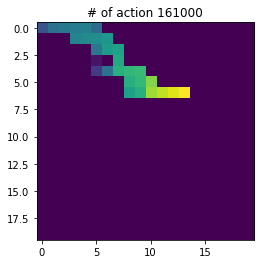

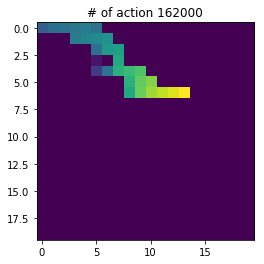

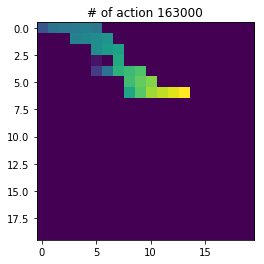

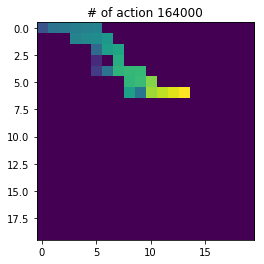

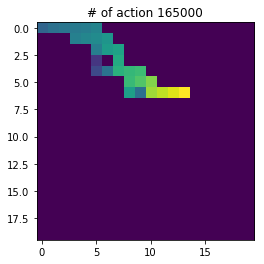

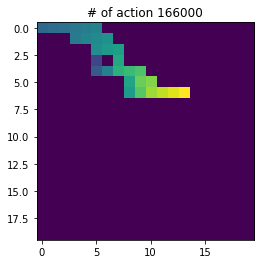

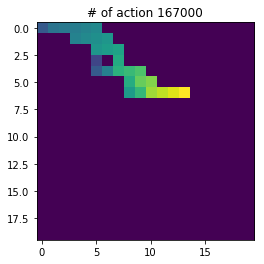

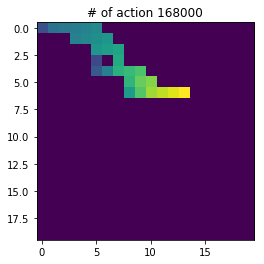

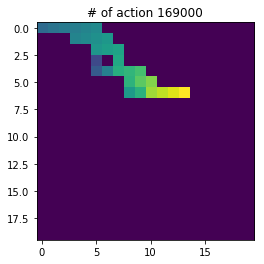

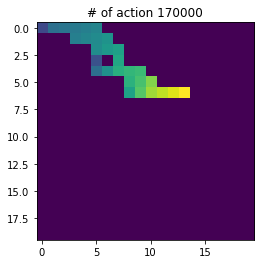

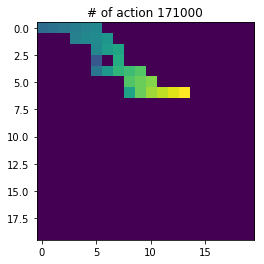

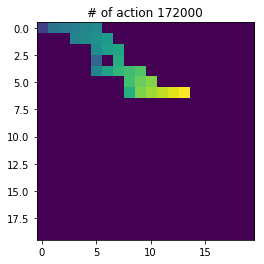

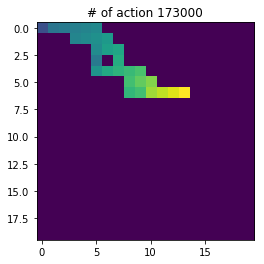

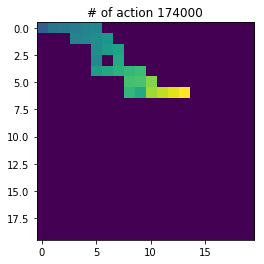

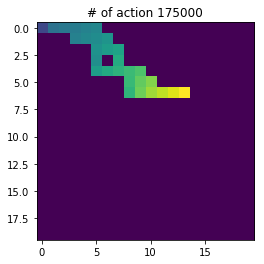

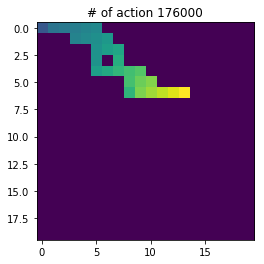

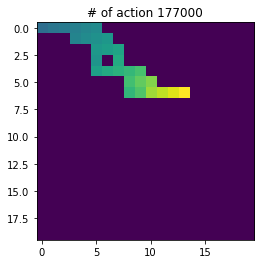

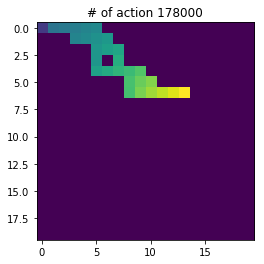

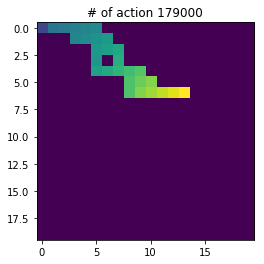

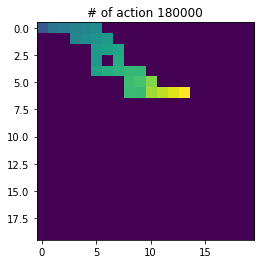

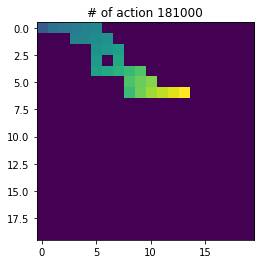

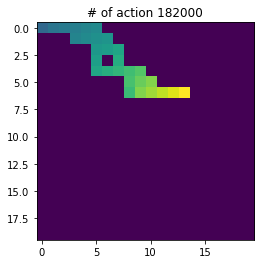

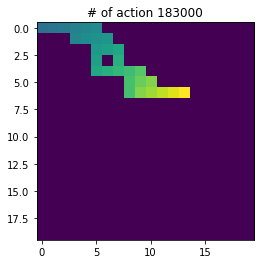

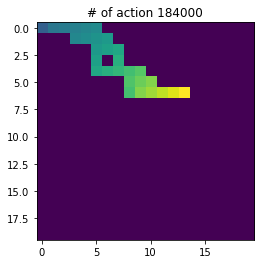

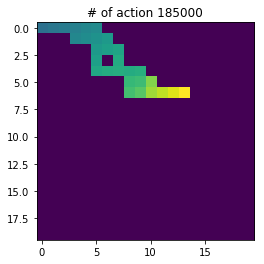

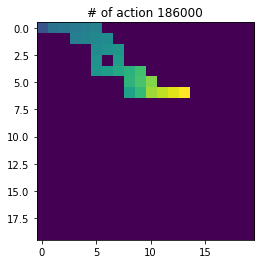

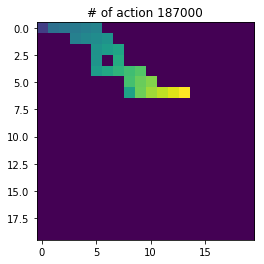

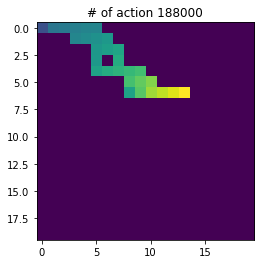

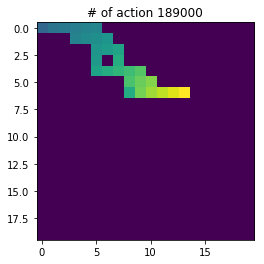

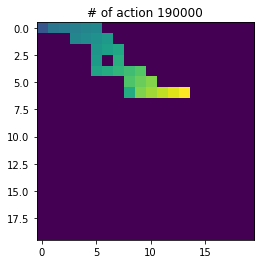

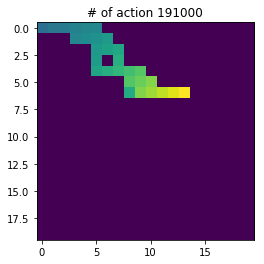

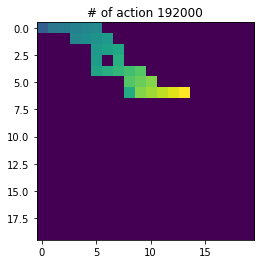

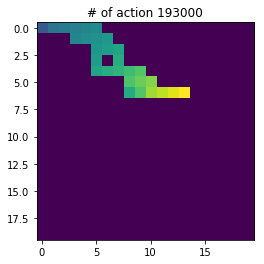

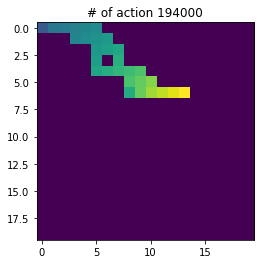

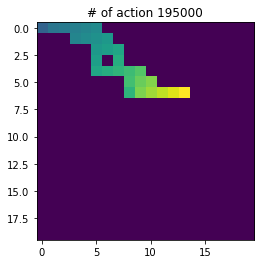

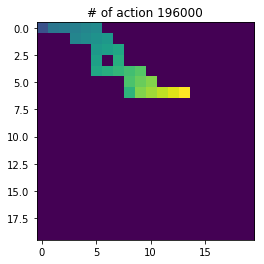

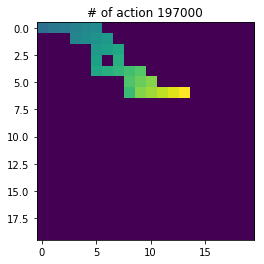

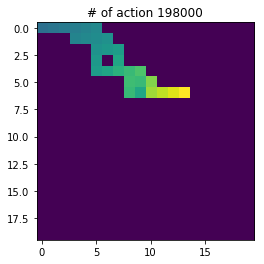

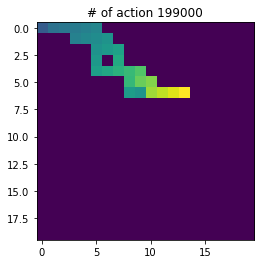

In [12]:
for i,v in enumerate(stacked_value_table[:200]):
    plt.imshow(v, interpolation='nearest')
    plt.clim(0,1)
    plt.title('# of action '+str(i*save_interval).zfill(3))
    plt.savefig('TD_PER_iter_'+str(i).zfill(4)+'.png')
#    plt.savefig('TD_RandomER_iter_'+str(i).zfill(4)+'.png')
    plt.show()